In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

# Load training and test data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df[train_df['threat']==1].sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
63559,aa1046cda3637efe,I KNOW IT'S ENGLAND BECAUSE IT SAYS UTC \n\nIN...,0,0,0,1,0,0
132566,c5430437bdd174a2,i hope you die you fucking pedophile. i gave y...,1,0,1,1,1,1
136178,d870a866ad68e393,what the hell man? why did you delete my page ...,1,0,1,1,1,0
42919,7277c53d39c83d63,"eat shit, fucko \n\nsuck my asshole, then die,...",1,1,1,1,1,0
143647,00a3157f7c3a24eb,"""\n\n Vandalize?! \n\nI would have ignored you...",0,0,0,1,0,0


In [4]:
cols_target = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']

In [5]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [7]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


In [10]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [11]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

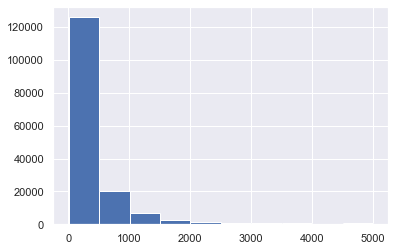

In [12]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

In [13]:
data = train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

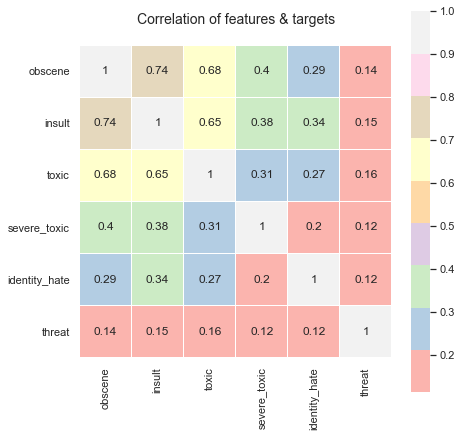

In [14]:
colormap = plt.cm.Pastel1
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [15]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

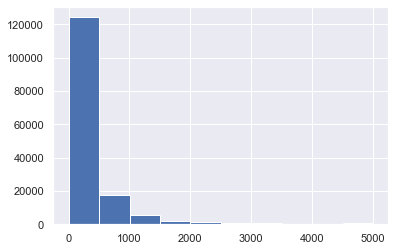

In [16]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

# Clean up the comment text

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [19]:
# clean the comment_text in test_df [Thanks, Pulkit Jha.]
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

# Define X from entire train & test data for use in tokenization by Vectorizer

In [20]:
train_df = train_df.drop('char_length',axis=1)

In [21]:
X = train_df.comment_text
test_X = test_df.comment_text

In [22]:
print(X.shape, test_X.shape)

(159571,) (153164,)


# Vectorize the data

In [23]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [24]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [25]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

In [31]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing obscene


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9832488359413678
... Processing insult


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9755344016143285
... Processing toxic


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9639784171309324
... Processing severe_toxic


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9920411603612185
... Processing identity_hate


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9939776024465599
... Processing threat
Training accuracy is 0.9981199591404453


C:\Users\Soyeon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999958,0.460885,0.999965,0.050124,0.972258,0.426804
1,0000247867823ef7,0.002463,0.000440,0.000402,0.000324,0.003252,0.000405
2,00013b17ad220c46,0.010797,0.000117,0.003203,0.000035,0.007652,0.001244
3,00017563c3f7919a,0.001342,0.002142,0.000972,0.000117,0.000835,0.000034
4,00017695ad8997eb,0.019408,0.000809,0.001252,0.000602,0.003271,0.000567


In [33]:
# generate submission file
submission_binary.to_csv('submission_binary.csv',index=False)

In [34]:
# create submission file
submission_chains = pd.read_csv('../input/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

FileNotFoundError: [Errno 2] No such file or directory: '../input/sample_submission.csv'

In [ ]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

In [ ]:
submission_chains.head()

In [ ]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

In [ ]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [ ]:
submission_combined.head()

In [ ]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)